<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/11_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention을 활용한 번역예시(Sequence to Sequence 적용)
- 출처: https://github.com/spro/practical-pytorch



    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My\ Drive/AISecurity

/content/drive/My Drive/AISecurity


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

데이터 로딩
==================
 - 수천 개의 영어-프랑스어 번역 쌍  ( 출처: https://www.manythings.org/anki/)

    I am cold.    J'ai froid.



# Lang 클래스 정의 
- 단어인덱스 처리(word2index, index2word), 단어의 빈도(word2count) 처리






In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

- 파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점 제거함



In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

- 데이터 파일을 읽기 위해 파일을 행으로 분할 한 다음 행을 쌍으로 분할
- 파일은 모두 영어 → 기타 언어이므로 다른 언어 → 영어로 번역하려면 reverse 플래그를 추가하여 쌍 변환필요




In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

- 많은 예제 문장이 있고 신속하게 학습하기를 원하기 때문에 데이터 짧고 간단한 문장으로 만 데이터 셋 정리
- 여기서 최대 길이는 10 단어 (종료 문장 부호 포함)이며 "I am"또는 "He is"등의 형태로 번역되는 문장으로 필터



In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

데이터 준비를위한 전체 과정 :
- 텍스트 파일을 분리하고, 줄을 쌍으로 분리
- 텍스트를 정규화하고 길이와 내용으로 필터링
- 문장을 쌍으로 단어리스트를 생성



In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['tu es vraiment dur au travail .', 'you re really a hard worker .']


# Seq2Seq 모델





# Encoder
- seq2seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 일부 값을 출력하는 RNN
- 인코더는 모든 입력 단어에 대해 벡터와 숨겨진 상태를 출력하고 다음 입력 단어에 대해 숨겨진 상태를 사용





In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)  # 입력 단어갯수, 임베딩 차원 //(2,5)예시 2개의 단어를 5개의 차원으로 워드임베딩
        self.gru = nn.GRU(hidden_size, hidden_size) # LSTM의 간략화 GRU 생성

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Decoder

- 가장 간단한 Seq2Seq는 처음의 마지막 출력만을 이용. 마지막 출력은이 전체 시퀀스에서 문맥을 인 코드하기 때문에 문맥 벡터 (컨텍스트 벡터)임. 이 벡터 이미지는 초기 은닉 상태로 사용

- 비용의 매 단계에서 입력 토큰과 은닉 상태가 처리. 초기 입력 토큰은 처음부터 시작 (start-of-string) <SOS>토큰이고, 첫 은닉 상태는 벡터 (인코더의 마지막 은닉 상태)




In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Attention Decoder
 - 인코더와 디코더 사이에 컨텍스트 벡터 만 전달되는 경우 해당 단일 벡터는 전체 문장을 인코딩하는 부담 발생

 - Attention을 디코더 네트워크는 디코더 자체 출력의 모든 단계에 대해 인코더 출력의 다른 부분에 "집중"할 수 있음. 먼저 Attention의 가중치 집합을 계산. 이들은 가중치 조합을 생성하기 위해 인코더 출력 벡터로 곱함.  attn_applied 코드에서 호출되어 입력 시퀀스의 특정 부분에 대한 정보를 포함해야하므로 디코더가 올바른 출력 단어를 선택하는 데 도움이 됨.

- Attention 가중치 계산은 attnDecoder의 입력 및 숨겨진 상태를 입력으로 사용하여 다른 피드 포워드 레이어로 수행
- 훈련 데이터에는 모든 크기의 문장이 있기 때문에 실제로 이 레이어를 만들고 훈련하려면 적용 할 수있는 최대 문장 길이 (인코더 출력의 경우 입력 길이)를 선택
- 최대 길이의 문장은 모든주의 가중치를 사용하고 짧은 문장은 처음 몇 개만 사용

In [12]:
 class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

학습
========

학습데이터 준비
-----------------------

- 학습을 위해서, 각 쌍마다 입력 Tensor (입력 문장의 단어 주소)와 목표 Tensor (목표 문장의 단어 주소)가 필요 
- 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가




In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

모델학습
------------------

- 훈련을 위해 인코더를 통해 입력 문장을 실행
- 모든 출력 및 최신 은닉 상태. 
- 디코더가 <SOS> 토큰을 첫 번째 입력으로, 마지막 숨겨진 상태
- 인코더를 첫 번째 숨겨진 상태로 설정

- Teacher forcing을 사용하면 수렴이 빨리 학습 된 네트워크가 잘못 때 알림을 사용

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

현재 시간과 진행률 %를 고려해 경과 된 시간과 남은 예상 시간을 출력하는 함수




In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# 전체 학습 과정은 다음과 같이 진행됩니다.

- 타이머 시작
- 옵티 마이저와 기준 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 그림 배열 시작




In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

matplotlib로 학습 plot_losses의 배열을 사용하여 도식화



In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

평가
==========

- 평가는 대부분의 학습과 동일하지만 목표가 단계마다 단계마다 예측을 되돌려 전달 - 단어를 예측할 때마다 그 단어를 출력 할 때마다 추가
- 만약 EOS 토큰을 예측하면 거기에서 멈춤 
- 나중에 도식화를 위해 Attention 출력을 저장




In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에있는 임의의 문장을 평가하고 입력, 목표 및 출력을 출력하여 주관적인 품질 판단




In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

학습과 평가
=======================


In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 41s (- 23m 37s) (5000 6%) 2.9134
3m 16s (- 21m 19s) (10000 13%) 2.3335
4m 52s (- 19m 30s) (15000 20%) 2.0018
6m 27s (- 17m 45s) (20000 26%) 1.7680
8m 3s (- 16m 7s) (25000 33%) 1.5424
9m 39s (- 14m 29s) (30000 40%) 1.3719
11m 14s (- 12m 51s) (35000 46%) 1.2484
12m 49s (- 11m 13s) (40000 53%) 1.1152
14m 23s (- 9m 35s) (45000 60%) 1.0569
15m 58s (- 7m 59s) (50000 66%) 0.9662
17m 35s (- 6m 23s) (55000 73%) 0.8889
19m 11s (- 4m 47s) (60000 80%) 0.7922
20m 46s (- 3m 11s) (65000 86%) 0.7313
22m 21s (- 1m 35s) (70000 93%) 0.6450
23m 59s (- 0m 0s) (75000 100%) 0.6238


In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> je vais desormais me taire .
= i m going to shut up now .
< i m going to do up now . <EOS>

> je ne suis pas naive .
= i m not naive .
< i m not a . <EOS>

> je ne vais pas y toucher .
= i m not going to touch it .
< i m not going to make it . <EOS>

> tu es trop confiant .
= you re too trusting .
< you re too trusting . <EOS>

> je fais de mon mieux .
= i m trying my best .
< i m doing my best . <EOS>

> je suis en train de regarder la television .
= i m watching tv .
< i m talking on television . <EOS>

> je suis pret pour le pire .
= i am prepared for the worst .
< i m ready for the worst . <EOS>

> tu es trop lent .
= you re too slow .
< you re too loud . <EOS>

> c est pour vous que je suis venu .
= you re the reason i came .
< you re the reason i came . <EOS>

> je ne suis pas pret a mourir .
= i m not ready to die .
< i am not ready to die . <EOS>



Visualizing Attention
---------------------




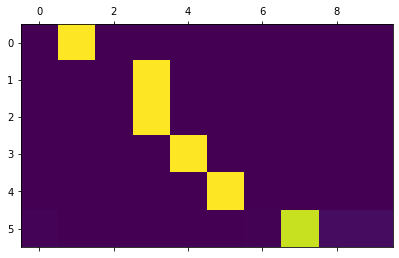

In [24]:
%matplotlib inline

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())



For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


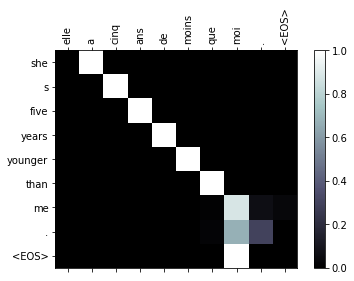

input = elle est trop petit .
output = she s too loud . <EOS>


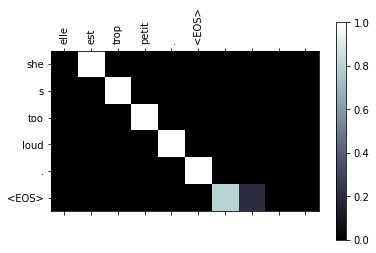

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


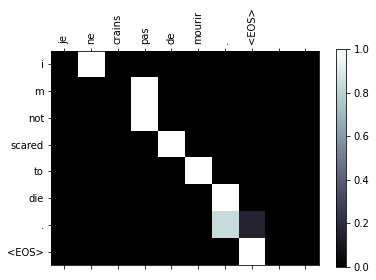

input = c est un jeune directeur plein de talent .
output = he s a talented young writer . <EOS>


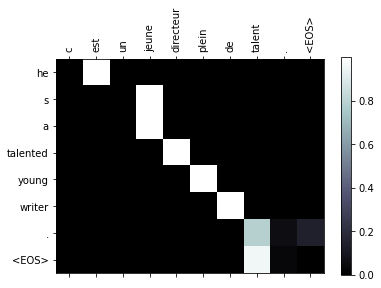

In [25]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")